# snowfall retrieval 
vsnow_hmrr.pro

# The retrieval uses the following:

    - RR:           true rainrate profile from input file
    - rainrate:     retrieved rainrate profile
    - rainrate_a:   a priori guess at rainrate (set to 5.0 mm/hr)
    
    - y_obs:        observed reflectivities
    - y_sim:        simulated refelectivities
    
    - S_a_matrix:   a priori error covariance matrix
    - S_y_matrix:   measurement error covariance matrix
    - S_x_matrix:   retrieval error covariance matrix
    
    - K_matrix:     matrix of Kernel functions
    - A_matrix:     averaging Kernel
    
    - y_contrib:    measurement contribution matrix (Dy Sy Dy^T)
    - a_contrib:    a priori contribution matrix (Da Sa Da^T)
    - LWP_contrib:  LWP contribution matrix (D_LWP sigma_LWP^2 DLWP^T)

In [1]:
import sys
sys.path.append('/Volumes/SANDISK128/Documents/Thesis/Python/')
sys.path.append('/Volumes/SANDISK128/Documents/Thesis/Python/weather_mast/')
import pandas as pd
import netCDF4
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
import createFolder as cF
import save_fig as SF
import math
import scipy.constants as const

import sub24hnum as sub
import read_MRR as pMRR
import calc_date as cd
import get_Haukeli_obs_data as obsDat


%matplotlib inline
from decimal import *
getcontext().prec = 7



In [2]:
date_blue = np.array([1,74,159])/255.   

fontsize = 30.
tick_fs = fontsize-2
label_fs = fontsize
legend_fs = fontsize
times = [0, 3, 6, 9,12, 15, 18, 21, 24]

def plt_refl(ax0, time_MRR, height_MRR, Ze, calday, day, calmon, year):
    levels = np.arange(-10.,30.1,0.2)
    CS = ax0.contourf(time_MRR, height_MRR , Ze, 
                  levels, cmap='jet', extend = 'max', alpha = 1.0, vmin = -10.,vmax=30., origin = 'lower')
    
    ax0.set_xlim([0, 24])
    
# add colorbar
    cbaxes = fig.add_axes([0.14, 0.1, .75, .02] )   #[left, bottom, width, height] 
    cbar = plt.colorbar(CS, ax=ax0, ticks=levels[::40], orientation = 'horizontal', cax=cbaxes)
    cbar.ax.set_xlabel('MRR reflectivity [dBz]', fontsize = label_fs)
    cbar.ax.tick_params(labelsize = tick_fs)
    
    

# labels
    
    ax0.set_xticks(np.arange(0,60*60*25,3*60*60))
    ax0.set_xticklabels(times, fontsize = label_fs)
    ax0.set_xlabel('time [hours]', fontsize = label_fs)

    ax0.set_ylabel('height [km]', fontsize = label_fs)
    ax0.set_ylim(0,3.5)
    ax0.set_yticks(np.arange(0,3500.,500.))
    yl = [0., '' , 1.0, '' , 2., '' , 3.]
    ax0.set_yticklabels(yl, fontsize = tick_fs)
    
    
# textbox
    ax0.text(0.02,0.96, '%s, %s %s %s' %(calday, day, calmon, year), verticalalignment = 'top',  
         horizontalalignment='left',
             transform = ax0.transAxes,
            color =date_blue, fontsize=fontsize,
           bbox={'facecolor':'white','alpha':1., 'pad':10})




In [7]:
year = '2016'
mon = '12'
t = ['25']
#t = ['20', '21', '22', '23', '24', '25', '26', '27']

In [8]:
sfig = 0
fig_dir = '../../Figures/MRR/'
cF.createFolder(fig_dir)
form = 'png'


In [21]:
t_a = []

/Volumes/SANDISK128/Applications/anaconda/envs/py36ECMWF/lib/python3.6/site-packages/ipykernel_launcher.py:67: RuntimeWarning: invalid value encountered in greater
/Volumes/SANDISK128/Applications/anaconda/envs/py36ECMWF/lib/python3.6/site-packages/ipykernel_launcher.py:63: RuntimeWarning: All-NaN slice encountered
/Volumes/SANDISK128/Applications/anaconda/envs/py36ECMWF/lib/python3.6/site-packages/ipykernel_launcher.py:66: RuntimeWarning: All-NaN slice encountered


ValueError: x and y must have same first dimension, but have shapes (1440,) and (14,)

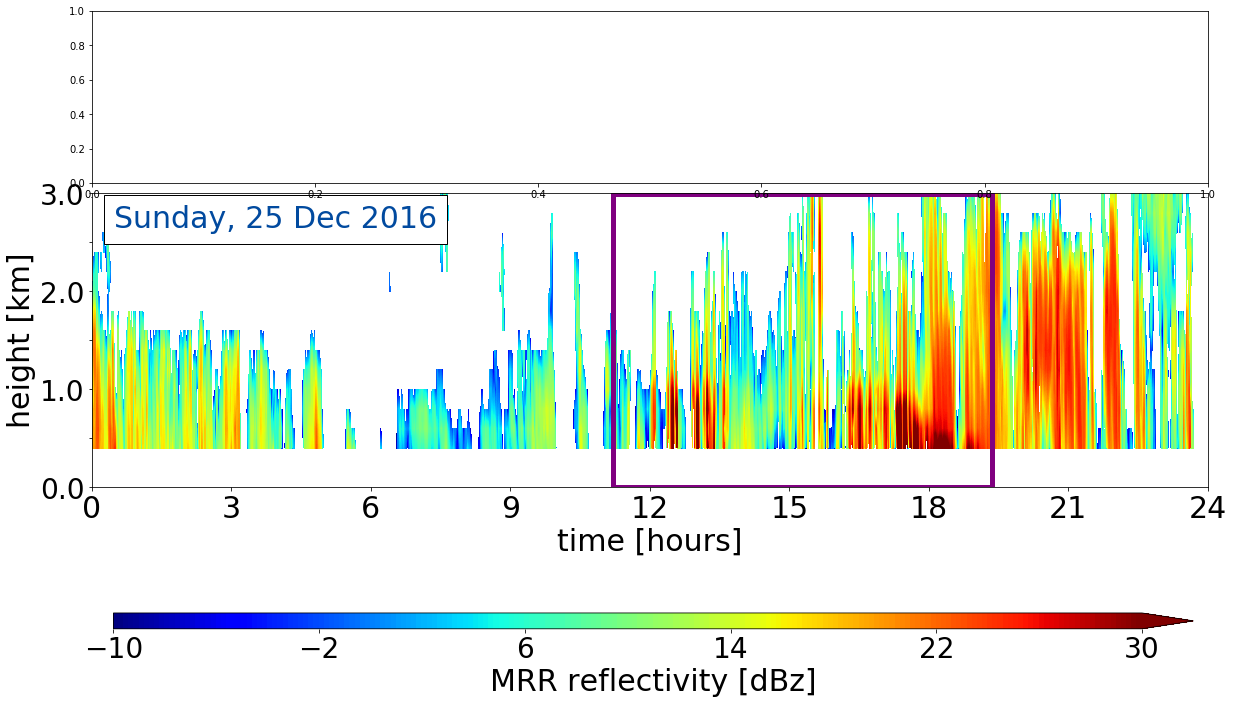

In [9]:
for day in t:
    calday, calmon = cd.get_dayname(year,mon, day)
#### 200m, processed MRR file ########################################
    MRR_dir = '../../Data/MRR/processed_MRR/'
    fnMRR = netCDF4.Dataset('%s/VMRR_%s%s%s.nc' %(MRR_dir,year,mon,day) ,'r')

    time_MRR = fnMRR.variables['time'][:]
    height_MRR = fnMRR.variables['height'][:]

    Ze = pMRR.read_and_mask(fnMRR,'Ze', np.nan)         # vertical Ze profile for retrieval
    Ze.astype(np.float32)
    W = pMRR.read_and_mask(fnMRR, 'mean_doppler_velocity', np.nan)    # Doppler data for fallspeed analyses
    W = (W) * (-1)

    num_kazr = Ze.shape[0]         # 1440, number of radar profiles
    nlayers = Ze.shape[1]          # 14, every 200m
    nx = nlayers + nlayers
#### processed MetNo, temperature file ########################################
    temp_dir = '../../Data/sfc_temp/nc'
    fnT = netCDF4.Dataset('%s/Haukeli_sfc_temp_%s%s%s.nc' %(temp_dir,year,mon,day),'r')

    time_temp = fnT.variables['time'][:].astype(np.float32)        # stime ...surface time
    sfc_temp = fnT.variables['sfc_temp'][:].astype(np.float32)    # stemp ...surface temperature

    h_snow = []
    bad = 0.0
## line 112:
#### START RETRIEVAL LOOP ###########################
    for icol2 in range(0,num_kazr):
#for icol2 in range(0,1):
        #print('icol2',icol2)
#### DEFINE VALUES ###########################
        t_apriori    = np.zeros(shape=nlayers, dtype=np.float32)
    
        slp          = np.zeros(shape=nx,dtype=np.float32)                     # retrieval vector  ??? same as ap_slp, ap_N0
        slpa         = np.zeros(shape=nx,dtype=np.float32)
    
        S_y_matrix   = []                     # measurement error covariance matrix;
        S_a_matrix   = []                     # a priori error covariance matrix;
    
        up_perturb   = np.zeros(shape=nx,dtype=np.float32)
        down_perturb = np.zeros(shape=nx,dtype=np.float32)
        y_max        = np.zeros(shape=nlayers,dtype=np.float32)
        y_min        = np.zeros(shape=nlayers,dtype=np.float32)
        y_sim        = np.zeros(shape=nlayers,dtype=np.float32)
        IWC_psd      = np.zeros(shape=nlayers,dtype=np.float32)
        K_matrix     = np.zeros(shape=(nx,nlayers),dtype=np.float32)
    
        slp_temp     = np.zeros(shape=nx,dtype=np.float32)
    
        S_x_matrix   = np.zeros(shape=(nx,nx),dtype=np.float32)     # retrieval error covariance matrix
##############################################

#### READ IN VALUES ###########################
        y_obs = Ze[icol2, :].astype(np.float32)                # vertical Ze profile for retrieval, observed reflectivities
        yobs = Ze[:,:].astype(np.float32)                      # Ze(time, profiles) for plots
        vdop = W[:,:].astype(np.float32)                       # get Doppler data for fallspeed analyses
##############################################

#### VALID VALUES ZE> -15, SURFACE TEMP < 2 ###########################
## line 125:    
#    surftemp = sfc_temp[icol2]
        vmax = np.nanmax(vdop[icol2,0:6])

#    snow = np.nanmax(y_obs)
        if (np.nanmax(Ze[icol2, :]) > -15. and sfc_temp[icol2] < 2.):      # ; Ze mask to save time if no snow, then go to the next Ze profile
            idx = np.where(np.logical_and(Ze[icol2, :] > -15., sfc_temp[icol2]< 2.))
            h_snow.append(400.)
##### in retrieval without h_snow ##########    
        else:
            h_snow.append(np.nan)
            continue
##############################################



#################################################################################################
######## the following is not in the retrieval just to plot the case  y_obs > -15., surftemp < 2.##################   
    list1 = (np.where(np.isnan(h_snow)))
    list1 = np.asarray(list1)

    list2 = []
    list2.append(list1[0,0])
    for i in range(0,list1.shape[1]-1):
        if (list1[0,i+1] - list1[0,i] > 1):
            list2.extend([list1[0,i], list1[0,i+1]])
    list2 = np.asarray(list2)

    idx2 = []
    for i in range(0,list2.shape[0]-1,2):
        if (list2[i+1] - list2[i] >=40):
            idx2.extend([list2[i], list2[i+1]])

    for k in range(0, np.asarray(idx2).shape[0],2):
        for i in range(idx2[k],idx2[k+1]):
            h_snow[i] = 1
##### PLOT REF AND T #######


### plot reflectivity
    fig = plt.figure(figsize=(20,11))
    gs = gridspec.GridSpec(10,1)
    ax0 = fig.add_subplot(gs[3:8,:])
    plt_refl(ax0, time_MRR, height_MRR, np.transpose(Ze), calday, day, calmon, year)



    for k in range(0, np.asarray(idx2).shape[0],2):
        dots = ax0.plot(np.asarray(time_MRR)[idx2[k]:idx2[k+1]],np.asarray(h_snow)[idx2[k]:idx2[k+1]],color='purple',
                   linestyle='-',linewidth=5)
        dots2 = ax0.plot(np.asarray(time_MRR)[idx2[k]:idx2[k+1]],2998.+np.asarray(h_snow)[idx2[k]:idx2[k+1]],color='purple',
                   linestyle='-',linewidth=5)
        ax0.axvline(np.asarray(time_MRR)[idx2[k]], color='purple', linestyle='-',linewidth=5)
        ax0.axvline(np.asarray(time_MRR)[idx2[k+1]], color='purple', linestyle='-',linewidth=5)
    


### plot sfc temp from MetNo data
    ax1 = fig.add_subplot(gs[0:3,:])
#    line = ax1.plot(time_temp, sfc_temp, color = 'r', label = 'Temp', linewidth = 4)
    line = ax1.plot(time_temp, t_apriori, color = 'r', label = 'Temp', linewidth = 4)
    ax1.axhline(y = 0., c ='darkgray', linewidth = 2.5, zorder = 0, linestyle = '--')
    ax1.axhline(y = -6., c ='darkgreen', linewidth = 2, zorder = 0, linestyle = '--')
    ax1.set_xlim([time_temp.min(),240000])


    ax1.set_yticks(np.arange(-6, 7,3))
    ax1.set_xticks(np.arange(0,250000,30000))
    ax1.set_xticklabels(times)
    ax1.set_ylabel('Temperature [$^\circ$C]',fontsize = label_fs)
    ax1.set_ylim([-6., 6.])
    ax1.tick_params(axis='both', which= 'major', labelsize=tick_fs)
    ax1.legend(loc='upper right', fontsize = legend_fs )
    ax1.tick_params(axis='both', which= 'major', labelsize=tick_fs)
    ax1.grid()

    plt.tight_layout()


    
    
    if sfig == 1:
        fig_name = 'MRR_sfcT_%s%s%s.%s' %(year,mon,day,form)
        SF.save_figure_landscape(fig_dir, fig_name, form)
        print('saved: %s/%s' %(fig_dir,fig_name))
    else:
        plt.show()
    plt.close()
#################################################################################################
    fnMRR.close()
    fnT.close()

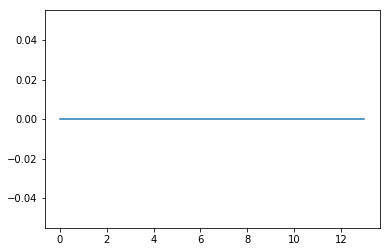

In [10]:
plt.plot(t_apriori)
plt.show()